## Home Credit Default Risk

## PART 4: Отбор признаков

В этой части я попробую подобрать признаки для итоговой модели. Все будет считаться на lightgbm. 

In [1]:
import numpy as np
import pandas as pd

from cross_validation_module import *
from submission_module import *

import pickle
from tqdm import tqdm_notebook
import lightgbm as lgb

import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 250)

In [2]:
with open('columns_vocab.pkl', 'rb') as f: 
    columns_vocab = pickle.load(f)
    
APPL_ID = 0
columns_vocab[APPL_ID].keys()

dict_keys(['column_id', 'column_target', 'columns_binary', 'columns_category', 'columns_float', 'columns_float_avg', 'columns_float_mode', 'columns_float_medi', 'columns_float_social_circle', 'new_features', 'columns_category_ohe', 'columns_float_log', 'columns_social_circle_log'])

In [3]:
with open('df_application_train_upd.pkl', 'rb') as f: 
    df_application_train = pickle.load(f)
    
with open('df_application_test_upd.pkl', 'rb') as f: 
    df_application_test = pickle.load(f)
#----------------------------------------------------#
with open('df_train_log_features.pkl', 'rb') as f: 
    df_train_log_features = pickle.load(f)
    
with open('df_test_log_features.pkl', 'rb') as f: 
    df_test_log_features = pickle.load(f)
#----------------------------------------------------#
with open('df_train_new_features.pkl', 'rb') as f: 
    df_train_new_features = pickle.load(f)
    
with open('df_test_new_features.pkl', 'rb') as f: 
    df_test_new_features = pickle.load(f)

In [4]:
print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)
print()
print('log features, train:', df_train_log_features.shape)
print('log features, test:', df_test_log_features.shape)
print()
print('new features, train:', df_train_new_features.shape)
print('new features, test:', df_test_new_features.shape)

application train: (307511, 324)
application test: (48744, 323)

log features, train: (307511, 5)
log features, test: (48744, 5)

new features, train: (307511, 45)
new features, test: (48744, 45)


In [5]:
df_application_train = pd.concat([df_application_train, df_train_log_features, df_train_new_features], axis=1)
df_application_test = pd.concat([df_application_test, df_test_log_features, df_test_new_features], axis=1)

print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 374)
application test: (48744, 373)


Удаление неиформативных признаков:

In [6]:
columns_empty = ['FLAG_MOBIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', \
                 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_12']

In [7]:
column_id = columns_vocab[APPL_ID]['column_id']
column_target = columns_vocab[APPL_ID]['column_target']

main_columns = columns_vocab[APPL_ID]['columns_float'] + \
                    columns_vocab[APPL_ID]['columns_binary'] + \
                    columns_vocab[APPL_ID]['columns_category_ohe']

for column in columns_empty: 
    main_columns.remove(column)
    
len(main_columns)

270

In [8]:
folds = get_cv_folds(df_application_train, column_target, n_splits=5)

------------------------------------------

In [12]:
params = {
    # Core parameters
    'objective': 'binary', 
    'learning_rate': 0.1, 
    'num_leaves': 31, 
    'num_threads': 0, 
    'seed': 0, 
    'random_state': 0, 
    
    # Learning Control Parameters
    #'early_stopping_round': 10, 
    
    # IO Parameters
    'verbose': -1, 
    
    # Objective Parameters
    'scale_pos_weight': 11, 
    
    # Metric Parameters
    'metric': 'auc', 
}
num_rounds = 100

In [13]:
columns = main_columns + \
            columns_vocab[APPL_ID]['columns_float_social_circle'] + \
            columns_vocab[APPL_ID]['columns_float_avg'] + \
            columns_vocab[APPL_ID]['columns_float_mode'] + \
            columns_vocab[APPL_ID]['columns_float_medi']

len(columns)

317

Еще раз запустим бейзлайн, чтобы иметь перед глазами результат на трейне и тесте и посмотрим на список признаков, отсортированных по значимости для модели: 

In [14]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

CPU times: user 4min 28s, sys: 12.5 s, total: 4min 40s
Wall time: 1min 43s


In [15]:
print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.8024979129931094
mean valid score: 0.7549067077793501


In [16]:
%%time
model = lgb.LGBMModel(**params)
X_train = df_application_train[columns]
y_train = df_application_train[column_target]

model.fit(X_train, y_train)
score = roc_auc_score(y_train, model.predict(X_train))
print('roc-auc:', score)

roc-auc: 0.7907015796581034
CPU times: user 1min 2s, sys: 2.33 s, total: 1min 4s
Wall time: 21.6 s


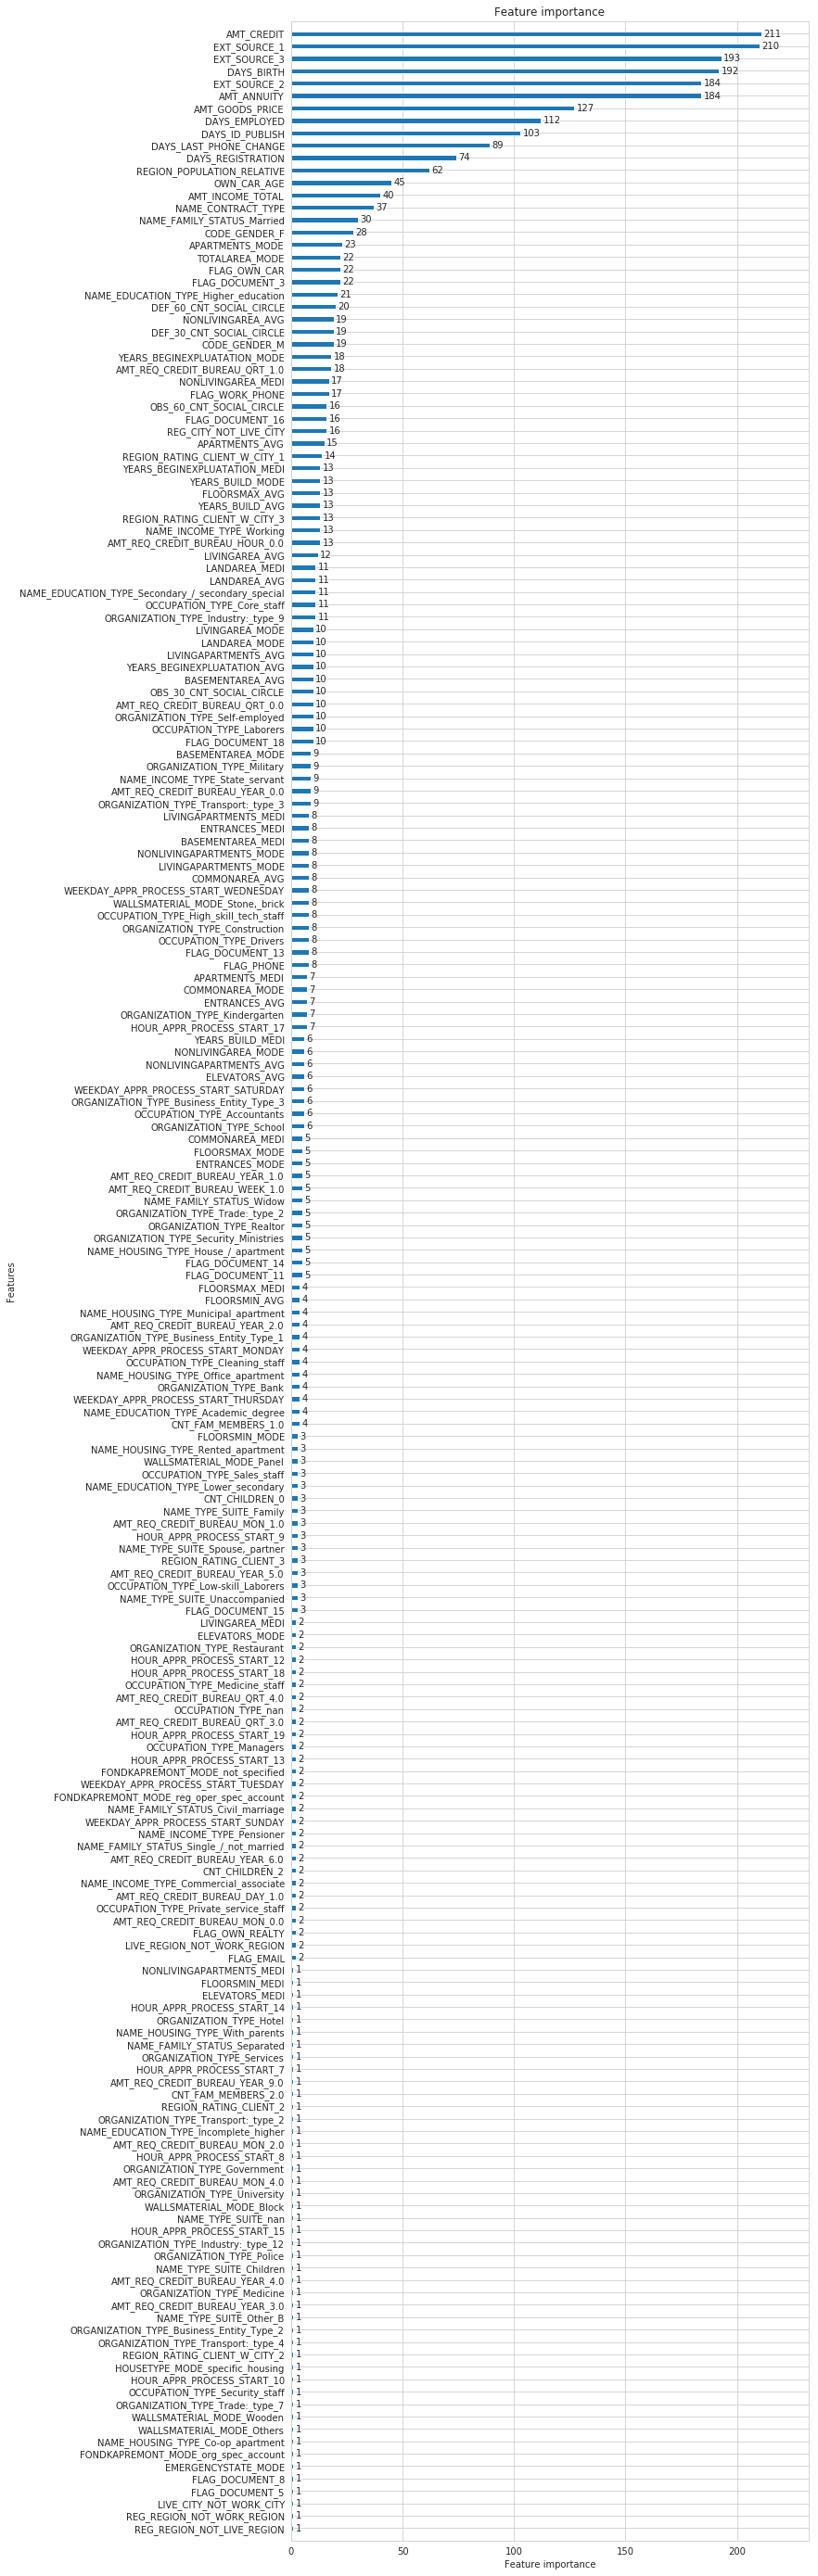

In [46]:
lgb.plot_importance(model, height=0.4, figsize=(10, 50));

Здесь мы видим, что наши предположения о полезности признаков подтвердились: важны данные из внешних источников, данные о размере кредита, возраст, годовая зарплата, разные признаки, выраженные в днях, возраст машины, пол. И даже такие признаки как **APARTMENTS_MODE, TOTALAREA_MODE** в первой 30-ке. 

#### Удаление групп _AVG and _MEDI 

Мне сразу очень хотелось что-нибудь сделать с этой пачкой признаков. Попробуем удалить две группы, группу **_MODE** оставим и посмотрим на результат. 

In [17]:
columns = main_columns + \
            columns_vocab[APPL_ID]['columns_float_social_circle'] + \
            columns_vocab[APPL_ID]['columns_float_mode']

len(columns)

289

In [18]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.8015353754574923
mean valid score: 0.7547295589759889
CPU times: user 3min 58s, sys: 10.4 s, total: 4min 9s
Wall time: 1min 38s


Качество немного стало хуже, это заметно в 3-м и 4-м знаках после запятой, на каггле тоже немного опустились.

Возможно, здесь стоит более осмысленно выкидывать признаки, не группами, а по одному. Но если честно, мне кажется, это несильно изменит roc-auc.

In [13]:
# private score = 0.74163
# public score = 0.74100
predict_submission_lightgbm(df_application_train, df_application_test, 
                           new_columns, column_target, params, num_rounds, 
                           'baseline_del_bad_feats-del_avg_medi_feats', 'lgb')

#### Логарифмирование признаков

Еще мне было интересно, скажется ли как-нибудь логарифмирование некоторых признаков на результах. 

Напомню, я изменила так всего 5 признаков: годовой доход **AMT_INCOME_TOTAL** и группу **CNT_SOCIAL_CIRCLE**. 

In [21]:
columns = columns_vocab[APPL_ID]['columns_float_log'] + \
                columns_vocab[APPL_ID]['columns_binary'] + \
                columns_vocab[APPL_ID]['columns_category_ohe'] + \
                columns_vocab[APPL_ID]['columns_social_circle_log'] + \
                columns_vocab[APPL_ID]['columns_float_avg'] + \
                columns_vocab[APPL_ID]['columns_float_mode'] + \
                columns_vocab[APPL_ID]['columns_float_medi']

for column in columns_empty: 
    columns.remove(column)
    
len(columns)

317

In [22]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.8025897959121711
mean valid score: 0.7550568511165421
CPU times: user 4min 31s, sys: 11.9 s, total: 4min 43s
Wall time: 1min 43s


Качество немного улучшилось. 

#### Новые признаки

Проверим, как поведет себя модель на сгенерированных признаках. Сделаем сейчас совсем банально и скормим модели все, что есть. Вдруг взлетит, но вряд ли :) 

In [38]:
columns = columns_vocab[APPL_ID]['columns_float_log'] + \
            columns_vocab[APPL_ID]['columns_binary'] + \
            columns_vocab[APPL_ID]['columns_category_ohe'] + \
            columns_vocab[APPL_ID]['columns_social_circle_log'] + \
            columns_vocab[APPL_ID]['columns_float_avg'] + \
            columns_vocab[APPL_ID]['columns_float_mode'] + \
            columns_vocab[APPL_ID]['columns_float_medi'] + \
            columns_vocab[APPL_ID]['new_features']

for column in columns_empty: 
    columns.remove(column)
    
len(columns)

362

In [39]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.8081450696831659
mean valid score: 0.754488306704076
CPU times: user 5min 43s, sys: 12.8 s, total: 5min 56s
Wall time: 2min 3s


По сравнению с бейзлайном на трейне немного стало лучше, на тесте наоборот. 

---------------------------

### Отбор признаков с Boruta

В этих данных хотелось бы отобрать самые важные признаки. 

Я уже давно собиралась попробовать этот алгоритм для отбора признаков, много раз слышала о нем. Посмотрим, поможет ли он в этой задаче.  

In [46]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from time import time
from tqdm import tqdm_notebook

In [64]:
columns = columns_vocab[APPL_ID]['columns_float_log'] + \
            columns_vocab[APPL_ID]['columns_binary'] + \
            columns_vocab[APPL_ID]['columns_category_ohe'] + \
            columns_vocab[APPL_ID]['columns_social_circle_log'] + \
            columns_vocab[APPL_ID]['columns_float_avg'] + \
            columns_vocab[APPL_ID]['columns_float_mode'] + \
            columns_vocab[APPL_ID]['columns_float_medi'] + \
            columns_vocab[APPL_ID]['new_features']

for column in columns_empty: 
    columns.remove(column)
    
len(columns)

362

In [49]:
time_start = time()

clf = RandomForestClassifier(n_estimators=25, max_depth=10, random_state=0, n_jobs=-1)

features_selector = BorutaPy(clf, n_estimators=25, verbose=2, random_state=0, max_iter=20)
features_selector.fit(df_application_train[columns].values, df_application_train['TARGET'])

time_end = time()

Iteration: 	1 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	2 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	3 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	4 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	5 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	6 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	7 / 20
Confirmed: 	0
Tentative: 	362
Rejected: 	0
Iteration: 	8 / 20
Confirmed: 	37
Tentative: 	25
Rejected: 	300
Iteration: 	9 / 20
Confirmed: 	37
Tentative: 	25
Rejected: 	300
Iteration: 	10 / 20
Confirmed: 	37
Tentative: 	25
Rejected: 	300
Iteration: 	11 / 20
Confirmed: 	37
Tentative: 	25
Rejected: 	300
Iteration: 	12 / 20
Confirmed: 	39
Tentative: 	18
Rejected: 	305
Iteration: 	13 / 20
Confirmed: 	39
Tentative: 	18
Rejected: 	305
Iteration: 	14 / 20
Confirmed: 	39
Tentative: 	18
Rejected: 	305
Iteration: 	15 / 20
Confirmed: 	39
Tentative: 	18
Rejected: 	305
Iteration: 	16 / 20
Confirmed: 	39
Tentative: 	1

In [50]:
print('time = ', (time_end - time_start)/60)

time =  19.466441893577574


In [52]:
with open('boruta.pkl', 'wb') as f: 
    pickle.dump(features_selector, f)

Примерно к 15-ой итерации алгоритм посчитал, что 39 признаков являются важными, около 300 признаков отклонены, в оставшихся алгоритм не уверен. 

Каждому признаку алгоритм присваивает ранг. Если ранг равен единице, то признак важный. У остальных ранг больше единицы. Как я поняла, самые плохие признаки будут иметь высокое значение ранга. 

Посмотрим на итоговую таблицу признак-ранг:

In [65]:
feature_selector_table = pd.DataFrame({'feature': columns, 'rank': features_selector.ranking_})
feature_selector_table.sort_values(by=['rank'], inplace=True)
feature_selector_table

,feature,rank
344,EXT_SOURCE_3 * REGION_POPULATION_RELATIVE,1
349,EXT_SOURCE prod * DAYS_BIRTH,1
348,EXT_SOURCE_mean * DAYS_BIRTH,1
324,AMT_CREDIT / AMT_INCOME_TOTAL,1
347,EXT_SOURCE_3 * DAYS_BIRTH,1
346,EXT_SOURCE_2 * DAYS_BIRTH,1
345,EXT_SOURCE_1 * DAYS_BIRTH,1
327,EXT_SOURCE mean,1
343,EXT_SOURCE_2 * REGION_POPULATION_RELATIVE,1
341,EXT_SOURCE_3 * AMT_GOODS_PRICE,1


Среди важных признаков оказалось много тех, которые были сгенерированы из исходных. 

Проверим, как изменится качество модели при использовании признаков с рангом 1:

In [66]:
confirmed_columns = feature_selector_table[feature_selector_table['rank'] == 1]['feature'].values
len(confirmed_columns)

39

In [56]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, confirmed_columns, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.7930234620021663
mean valid score: 0.7443450535477535
CPU times: user 2min 9s, sys: 3.87 s, total: 2min 13s
Wall time: 58.3 s


In [57]:
# boruta, rank = 1
# private score = 0.73327
# public score = 0.73053
predict_submission_lightgbm(df_application_train, df_application_test, 
                           confirmed_columns, column_target, params, num_rounds, 
                           'boruta-1', 'lgb')

Качество упало примерно на 1% и локально, и на kaggle, однако мы использовали всего 39(!) признаков из 362, которые были сгенерированы и подготовлены из исходных 122. Это означает, что основная информация извлекается только из них. И по-хорошему стоило бы еще проверить признаки на коллинеарность, наверняка еще можно снизить размерность. Большая часть категориальных признаков находится где-то ниже ранга 100. И еще мы узнали, что алгоритм Boruta работает:)  

Далее я хочу посмотреть, что будет если постепенно добавлять признаки к уже имеющимся подтверженным алгоритмом. Я ожидаю, что вначале качество немного вырастет, а потом в какой-то момент начнет падать или не меняться. 

-----------------------------------------

In [73]:
%%time
features_number = []
train_roc_auc_scores = []
valid_roc_auc_scores = []

for rank in tqdm_notebook(np.arange(1, 33)*10): 
    columns_rank = feature_selector_table[(feature_selector_table['rank'] <= rank)]['feature'].values
    
    train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, 
                                    columns_rank, column_target, folds, \
                                    params=params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)
    
    mean_train_score = np.mean(train_roc_auc)
    mean_valid_score = np.mean(valid_roc_auc)
    
    features_number.append(len(columns_rank))
    train_roc_auc_scores.append(mean_train_score)
    valid_roc_auc_scores.append(mean_valid_score)
    
    print('rank:', rank)
    print('features, number:', len(columns_rank))
    print('train score:', mean_train_score)
    print('valid score:', mean_valid_score)
    print('-----------------------------------------------------------')

rank: 10
features, number: 48
train score: 0.7970410147994593
valid score: 0.7463622223596291
-----------------------------------------------------------
rank: 20
features, number: 59
train score: 0.8005172175872792
valid score: 0.7490485368665902
-----------------------------------------------------------
rank: 30
features, number: 69
train score: 0.8035284791943009
valid score: 0.7514619134014924
-----------------------------------------------------------
rank: 40
features, number: 79
train score: 0.8040147681438672
valid score: 0.7514459945581743
-----------------------------------------------------------
rank: 50
features, number: 89
train score: 0.8048953821889132
valid score: 0.751988423575354
-----------------------------------------------------------
rank: 60
features, number: 99
train score: 0.8051087184511465
valid score: 0.7516828520457368
-----------------------------------------------------------
rank: 70
features, number: 109
train score: 0.8052789791622004
valid score: 0

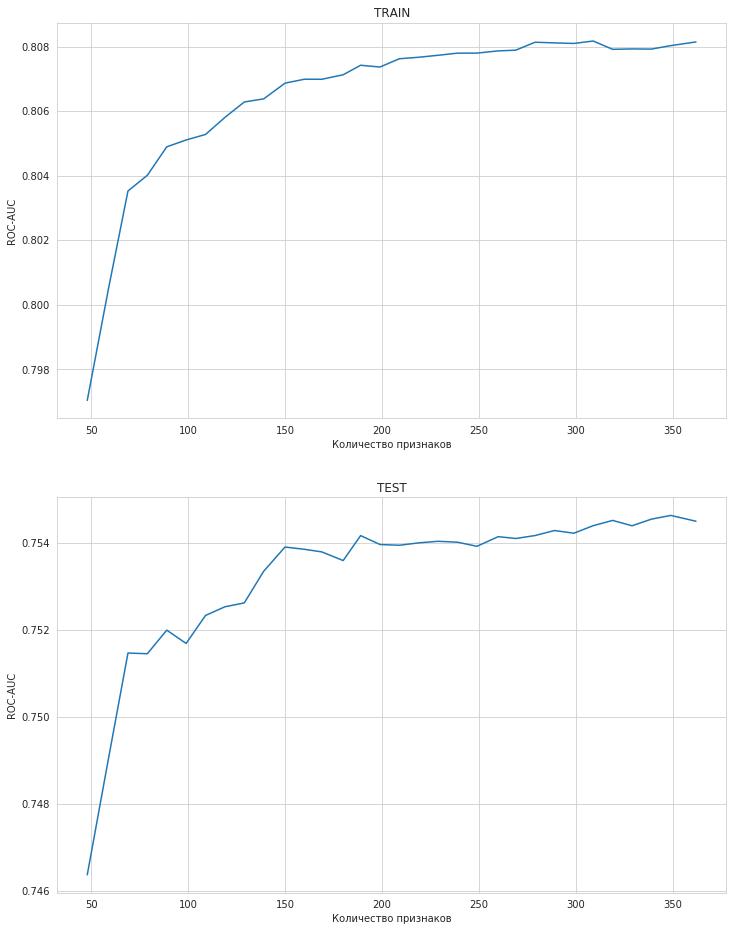

In [75]:
fig, axes = plt.subplots(nrows=2, figsize=(12, 16))
axes[0].plot(features_number, train_roc_auc_scores)
axes[1].plot(features_number, valid_roc_auc_scores)

axes[0].set_title('TRAIN')
axes[1].set_title('TEST')
axes[0].set_xlabel('Количество признаков')
axes[1].set_xlabel('Количество признаков')
axes[0].set_ylabel('ROC-AUC')
axes[1].set_ylabel('ROC-AUC')
plt.show()

--------------------------------

Сделаем несколько посылок на каггл: 

In [70]:
columns_rank10 = feature_selector_table[feature_selector_table['rank'] <= 10]['feature'].values
len(columns_rank10)

48

In [72]:
# boruta, rank <= 10
# features num = 48 
# local train score = 0.79704
# local test score = 0.74636

# private score = 0.73756
# public score = 0.73269
predict_submission_lightgbm(df_application_train, df_application_test, 
                            columns_rank10, column_target, params, num_rounds, 'boruta-10', 'lgb')

-----------------------------------------

In [77]:
columns_rank50 = feature_selector_table[feature_selector_table['rank'] <= 50]['feature'].values
len(columns_rank50)

89

In [78]:
# boruta, rank <= 50
# features num = 89 
# local train score = 0.804895
# local test score = 0.751988

# private score = 0.74176
# public score = 0.73964
predict_submission_lightgbm(df_application_train, df_application_test, 
                            columns_rank50, column_target, params, num_rounds, 'boruta-50', 'lgb')

---------------------

In [79]:
columns_rank110 = feature_selector_table[feature_selector_table['rank'] <= 110]['feature'].values
len(columns_rank110)

150

In [80]:
# boruta, rank <= 110
# features num = 150
# local train score = 0.8068680793065294
# local test score = 0.7538988717485562

# private score = 0.74426
# public score = 0.74082
predict_submission_lightgbm(df_application_train, df_application_test, 
                            columns_rank110, column_target, params, num_rounds, 'boruta-110', 'lgb')

Немного подняли качество, на private таблице в kaggle вообще лучший пока что результат. Пожалуй, остановлюсь на 150 признаках и остальные тащить в модель при подборе параметров не буду. 

In [83]:
# Сохранение признаков, полученных в Boruta
columns_vocab[APPL_ID]['boruta_110'] = columns_rank110

with open('columns_vocab.pkl', 'wb') as f: 
    pickle.dump(columns_vocab, f)